
# Import libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from PIL import Image

import os
import xml.etree.ElementTree as ET

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.models import Sequential
from scipy.io import loadmat
import pandas as pd
import h5py


2023-10-25 09:26:29.794769: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 09:26:32.957448: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data Preparation

In [12]:
#Reading the meta data file
mat_train = loadmat('/home/azureuser/sourav/car classification/stanford_car_data/devkit/cars_test_annos.mat')
mat_test = loadmat('/home/azureuser/sourav/car classification/stanford_car_data/devkit/cars_test_annos.mat')
meta = loadmat('/home/azureuser/sourav/car classification/stanford_car_data/devkit/cars_meta.mat')

In [16]:
#saving the names of the vehicle label
labels = list()
for l in meta['class_names'][0]:
    labels.append(l[0])
print(f'Number of classes are {len(labels)}')


Number of classes are 196


In [19]:
mat_train['annotations'][0]

array([(array([[30]], dtype=uint8), array([[52]], dtype=uint8), array([[246]], dtype=uint8), array([[147]], dtype=uint8), array(['00001.jpg'], dtype='<U9')),
       (array([[100]], dtype=uint8), array([[19]], dtype=uint8), array([[576]], dtype=uint16), array([[203]], dtype=uint8), array(['00002.jpg'], dtype='<U9')),
       (array([[51]], dtype=uint8), array([[105]], dtype=uint8), array([[968]], dtype=uint16), array([[659]], dtype=uint16), array(['00003.jpg'], dtype='<U9')),
       ...,
       (array([[33]], dtype=uint8), array([[27]], dtype=uint8), array([[602]], dtype=uint16), array([[252]], dtype=uint8), array(['08039.jpg'], dtype='<U9')),
       (array([[33]], dtype=uint8), array([[142]], dtype=uint8), array([[521]], dtype=uint16), array([[376]], dtype=uint16), array(['08040.jpg'], dtype='<U9')),
       (array([[77]], dtype=uint8), array([[73]], dtype=uint8), array([[506]], dtype=uint16), array([[380]], dtype=uint16), array(['08041.jpg'], dtype='<U9'))],
      dtype=[('bbox_x1', 'O'

In [15]:
train = list()
for example in mat_train['annotations'][0]:
    label = labels[example[-2][0][0]-1]
    image = example[-1][0]
    bbox_x1 = example[0][0][0]
    bbox_x2 = example[1][0][0]
    bbox_y1 = example[2][0][0]
    bbox_y2 = example[3][0][0]
    train.append((image,bbox_x1, bbox_x2, bbox_y1, bbox_y2, label))
    

IndexError: list index out of range

In [42]:
test = list()
for example in mat_test['annotations'][0]:
    image = example[-1][0]
    test.append(image)

validation_size = int(len(train) * 0.10)
test_size = int(len(train) * 0.20)

validation = train[:validation_size].copy()
np.random.shuffle(validation)
train = train[validation_size:]

test = train[:test_size].copy()
np.random.shuffle(test)
train = train[test_size:]

In [46]:
test_path = "stanford car/cars_test/cars_test/"
train_path = "stanford car/cars_train/cars_train/"
org_path = "stanford car/cars_train/cars_train/"
org_path_test = "stanford car/cars_test/cars_test/"

In [7]:
with open('stanford car/cars_data.csv', 'w+') as f:
    [f.write('TRAIN,%s,%s%s,%s,%s,%s,%s,%s,%s\n' %(train_path, org_path, img, bbox_x1, bbox_x2, bbox_y1, bbox_y2, lab,img)) for img, bbox_x1, bbox_x2, bbox_y1, bbox_y2, lab in train]
    [f.write('VALIDATION,%s,%s%s,%s,%s,%s,%s,%s,%s\n' %(train_path, org_path, img, bbox_x1, bbox_x2, bbox_y1, bbox_y2, lab,img)) for img, bbox_x1, bbox_x2, bbox_y1, bbox_y2, lab in validation]
    [f.write('TEST,%s,%s,%s\n' %(test_path, org_path_test, img)) for img,_,_,_,_,_ in test]# encoding:utf8

In [21]:

data_met = pd.read_csv('stanford_car_data/cars_data.csv')

In [22]:
data_met.describe()

,BBOX_X2,BBOX_Y1,BBOX_Y2
count,6516.000000,6516.000000,6516.000000
mean,109.036219,637.808625,416.864794
std,106.036613,410.210025,272.715397
min,1.000000,76.000000,47.000000
25%,42.000000,392.000000,248.000000
50%,80.000000,569.000000,361.000000
75%,139.000000,747.250000,479.000000
max,1508.000000,5205.000000,3389.000000


In [23]:
# creating training data set
train_data_met = data_met.dropna()
train_data_met

,TYPE,TRAIN_PATH,ORG_PATH,BBOX_X1,BBOX_X2,BBOX_Y1,BBOX_Y2,LABEL,IMAGE
0,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02443.jpg,74,62.0,617.0,411.0,HUMMER H3T Crew Cab 2010,02443.jpg
1,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02444.jpg,70,60.0,737.0,541.0,Ford F-150 Regular Cab 2012,02444.jpg
2,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02445.jpg,30,99.0,743.0,427.0,Buick Rainier SUV 2007,02445.jpg
3,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02446.jpg,60,126.0,839.0,578.0,Lamborghini Diablo Coupe 2001,02446.jpg
4,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02447.jpg,64,58.0,341.0,177.0,Ram C/V Cargo Van Minivan 2012,02447.jpg
...,...,...,...,...,...,...,...,...,...
6511,VALIDATION,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/00466.jpg,104,261.0,511.0,480.0,Scion xD Hatchback 2012,00466.jpg
6512,VALIDATION,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/00038.jpg,16,89.0,459.0,326.0,Dodge Charger SRT-8 2009,00038.jpg
6513,VALIDATION,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/00754.jpg,60,2.0,578.0,440.0,Dodge Durango SUV 2007,00754.jpg
6514,VALIDATION,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/00211.jpg,11,47.0,598.0,365.0,Rolls-Royce Ghost Sedan 2012,00211.jpg


In [27]:
#removing '/' before creating folder as it is a problem to give paths
train_data_met['LABEL'] = train_data_met['LABEL'].str.replace('/','')
brand = train_data_met['LABEL'].unique()
len(brand)
print(brand)

['HUMMER H3T Crew Cab 2010' 'Ford F-150 Regular Cab 2012'
 'Buick Rainier SUV 2007' 'Lamborghini Diablo Coupe 2001'
 'Ram CV Cargo Van Minivan 2012' 'Dodge Dakota Club Cab 2007'
 'Honda Odyssey Minivan 2012' 'Buick Verano Sedan 2012'
 'BMW 1 Series Convertible 2012'
 'Bentley Continental Flying Spur Sedan 2007'
 'Dodge Ram Pickup 3500 Crew Cab 2010' 'GMC Terrain SUV 2012'
 'Audi TT RS Coupe 2012' 'Acura TSX Sedan 2012'
 'Chevrolet Camaro Convertible 2012' 'Chevrolet Monte Carlo Coupe 2007'
 'Volkswagen Golf Hatchback 1991' 'Jeep Wrangler SUV 2012'
 'Hyundai Genesis Sedan 2012' 'Audi A5 Coupe 2012'
 'BMW 3 Series Sedan 2012' 'GMC Canyon Extended Cab 2012'
 'Hyundai Elantra Touring Hatchback 2012' 'BMW M5 Sedan 2010'
 'Hyundai Veloster Hatchback 2012' 'Lamborghini Aventador Coupe 2012'
 'Dodge Charger Sedan 2012' 'Chrysler Crossfire Convertible 2008'
 'Audi TTS Coupe 2012' 'Isuzu Ascender SUV 2008' 'Spyker C8 Coupe 2009'
 'Audi S5 Convertible 2012' 'Dodge Caliber Wagon 2012' 'BMW M3 Coup

/tmp/ipykernel_1836/1995083760.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_met['LABEL'] = train_data_met['LABEL'].str.replace('/','')


# **Data Pre-processing - Cropping the car out of every image**
## localisation

In [30]:
train_data_met.head(10)

,TYPE,TRAIN_PATH,ORG_PATH,BBOX_X1,BBOX_X2,BBOX_Y1,BBOX_Y2,LABEL,IMAGE
0,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02443.jpg,74,62.0,617.0,411.0,HUMMER H3T Crew Cab 2010,02443.jpg
1,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02444.jpg,70,60.0,737.0,541.0,Ford F-150 Regular Cab 2012,02444.jpg
2,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02445.jpg,30,99.0,743.0,427.0,Buick Rainier SUV 2007,02445.jpg
3,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02446.jpg,60,126.0,839.0,578.0,Lamborghini Diablo Coupe 2001,02446.jpg
4,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02447.jpg,64,58.0,341.0,177.0,Ram CV Cargo Van Minivan 2012,02447.jpg
5,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02448.jpg,3,226.0,1017.0,621.0,Dodge Dakota Club Cab 2007,02448.jpg
6,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02449.jpg,61,150.0,595.0,378.0,Honda Odyssey Minivan 2012,02449.jpg
7,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02450.jpg,51,99.0,595.0,382.0,Buick Verano Sedan 2012,02450.jpg
8,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02451.jpg,29,11.0,269.0,159.0,BMW 1 Series Convertible 2012,02451.jpg
9,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02452.jpg,20,44.0,249.0,161.0,Bentley Continental Flying Spur Sedan 2007,02452.jpg


In [12]:
#creating a new folder to store cropped car images
os.mkdir('stanford_car_data/data')
for brands in brand:
    os.mkdir('stanford_car_data/data/' + brands)
print('Created {} folders to store cropped images of the different types.'.format(len(os.listdir('stanford car/data'))))

Created 196 folders to store cropped images of the different types.


In [14]:
for i in range(0,6516):
    a =train_data_met['path'][i]
    xmin = int(train_data_met['BBOX_X1'][i]) 
    ymin = int(train_data_met['BBOX_X2'][i])
    xmax = int(train_data_met['BBOX_Y1'][i])
    ymax = int(train_data_met['BBOX_Y2'][i])
    print(i,a,xmin,xmax,ymin,ymax)
    img = Image.open(a)
    img = img.crop((xmin, ymin, xmax, ymax))
    img = img.convert('RGB')
    img = img.resize((224, 224))
    filename = train_data_met['img'][i]
    img.save('stanford_car_data/data/' + train_data_met['label'][i] + '/'+filename)

0 stanford car/cars_train/cars_train/02443.jpg 74 617 62 411
1 stanford car/cars_train/cars_train/02444.jpg 70 737 60 541
2 stanford car/cars_train/cars_train/02445.jpg 30 743 99 427
3 stanford car/cars_train/cars_train/02446.jpg 60 839 126 578
4 stanford car/cars_train/cars_train/02447.jpg 64 341 58 177
5 stanford car/cars_train/cars_train/02448.jpg 3 1017 226 621
6 stanford car/cars_train/cars_train/02449.jpg 61 595 150 378
7 stanford car/cars_train/cars_train/02450.jpg 51 595 99 382
8 stanford car/cars_train/cars_train/02451.jpg 29 269 11 159
9 stanford car/cars_train/cars_train/02452.jpg 20 249 44 161
10 stanford car/cars_train/cars_train/02453.jpg 24 450 61 306
11 stanford car/cars_train/cars_train/02454.jpg 50 605 167 392
12 stanford car/cars_train/cars_train/02455.jpg 79 563 97 353
13 stanford car/cars_train/cars_train/02456.jpg 40 224 38 155
14 stanford car/cars_train/cars_train/02457.jpg 126 885 227 551
15 stanford car/cars_train/cars_train/02458.jpg 25 520 57 297
16 stanford 

# **Using Keras ImageDataGenerator to rescale and augment data, and split it into Training and Validation sets**

In [39]:
train_directory = "stanford car data/data"
#Data Augmentation and train-val split
#keras_preprocessing.image  ImageDataGenerator is used to generate tensor of image with realtime data augmentation.
#rescale helps to reduce the parameter
#shear range determines the maximum extent to which an object or an image can be distorted along a particular axis.
#zoom range is the range of random zoom
sd_gen = ImageDataGenerator(
    rescale = 1./255,
    shear_range=0.1,
    zoom_range=0.1,
    height_shift_range=0.1,
    width_shift_range=0.1,
    rotation_range=10,
    horizontal_flip=True,
    validation_split=0.2,
)

In [40]:
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory
#Loading train data
train_gen = sd_gen.flow_from_directory(
    train_directory,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

#Loading val data
val_gen = sd_gen.flow_from_directory(
    train_directory,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 5293 images belonging to 196 classes.
Found 1222 images belonging to 196 classes.


In [41]:
# Wrap the DirectoryIterator with a tf.data.Dataset object
val_dataset = tf.data.Dataset.from_generator(
    lambda: val_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,196), dtype=tf.int32)
    )
)

# Repeat the dataset for the specified number of epochs
val_dataset = val_dataset.repeat(150)

2023-10-25 09:50:46.996180: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# **Running a Random Generator to visualize a few images post Pre-processing and Augmentation**

Found 5293 images belonging to 196 classes.


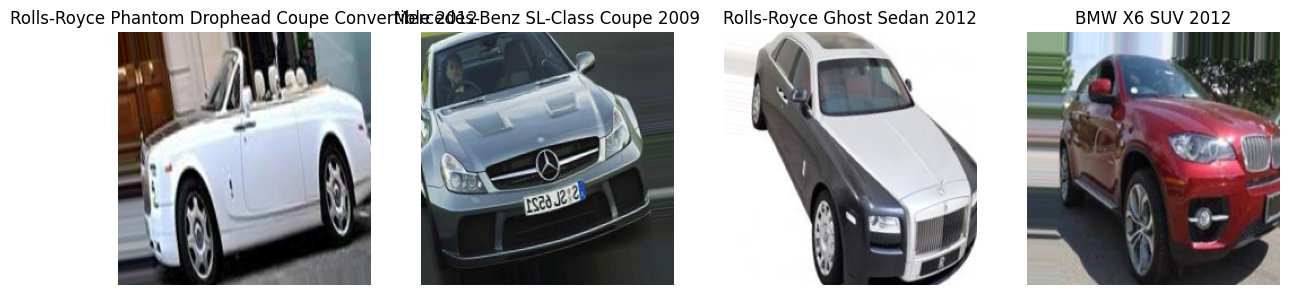

In [42]:
#Code referenced from https://github.com/renxzen/stanfordDogs/blob/main/stanfordDogs.ipynb

rand_gen = sd_gen.flow_from_directory(
    train_directory,
    target_size=(224,224),
    batch_size=1,
    class_mode='categorical',
    subset='training'
)

plt.figure(figsize=(15,10))
for i in range(4):
    rand_img = next(rand_gen)
    name = list(rand_gen.class_indices.keys())[list(rand_gen.class_indices.values()).index(np.argmax(rand_img[1]))]
    plt.subplot(1,4,i+1)
    plt.title(name)
    plt.imshow(rand_img[0].reshape(224, 224, 3))
    plt.axis('off')

# **Training the ResNet50V2 pre-trained model**

In [43]:
# ResNet50V2 Pre-trained Model
# https://keras.io/api/applications/

base_model_rsn = keras.applications.ResNet50V2(
    weights = 'imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

#Architecture referenced from https://github.com/renxzen/stanfordDogs/blob/main/stanfordDogs.ipynb
x = keras.layers.Flatten()(base_model_rsn.output)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(2048, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(2048, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)

out = keras.layers.Dense(196, activation='softmax')(x)

base_model_rsn.trainable = False
for layer in base_model_rsn.layers:
    layer.trainable = False

In [44]:
model_rsn = keras.Model(base_model_rsn.input, out)

#Compiling the model
model_rsn.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy']
)

In [45]:
#Setting checkpoints to save epochs with best validation accuracy
checkpoint_path = "training/cp-best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
callbacks = [ keras.callbacks.ModelCheckpoint(checkpoint_dir, monitor='val_accuracy', verbose=1, save_weights_only = True, save_best_only = True, mode='max')]

In [46]:
#Training the model
history_rsn = model_rsn.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=80,
    validation_steps=8,  
    epochs=60,
    verbose=1,
    callbacks = callbacks
)

Epoch 1/60
80/80 [==============================] - ETA: 0s - loss: 13.6989 - accuracy: 0.0391
Epoch 1: val_accuracy improved from -inf to 0.01953, saving model to training
80/80 [==============================] - 82s 973ms/step - loss: 13.6989 - accuracy: 0.0391 - val_loss: 45.4106 - val_accuracy: 0.0195
Epoch 2/60
80/80 [==============================] - ETA: 0s - loss: 7.3932 - accuracy: 0.0758
Epoch 2: val_accuracy improved from 0.01953 to 0.06641, saving model to training
80/80 [==============================] - 87s 1s/step - loss: 7.3932 - accuracy: 0.0758 - val_loss: 6.8957 - val_accuracy: 0.0664
Epoch 3/60
80/80 [==============================] - ETA: 0s - loss: 4.4771 - accuracy: 0.1307
Epoch 3: val_accuracy improved from 0.06641 to 0.13672, saving model to training
80/80 [==============================] - 86s 1s/step - loss: 4.4771 - accuracy: 0.1307 - val_loss: 4.3185 - val_accuracy: 0.1367
Epoch 4/60
80/80 [==============================] - ETA: 0s - loss: 3.7775 - accuracy

In [47]:
model_rsn.save("model lib/ep=60_lr=0.01.model", save_format="h5")

/home/azureuser/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [48]:
model_rsn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [29]:
model_rsn.save("novalcarresnet50v2l_150e.model", save_format="h5")

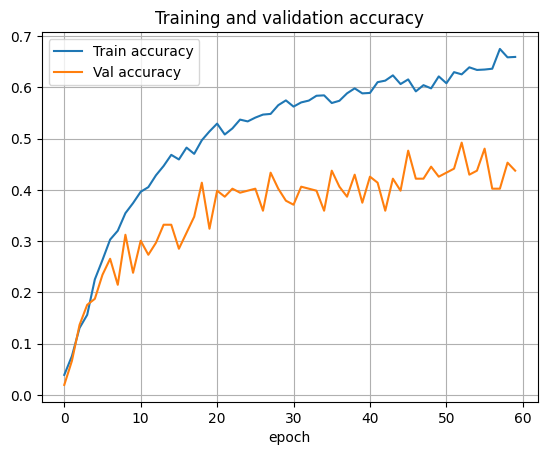

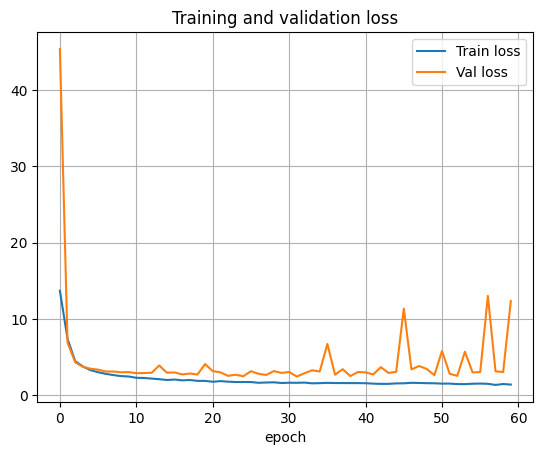

In [49]:
#Plotting graphs to visualize the progression of training and validation accuracy and loss curves
fig = plt.figure()

plt.plot(history_rsn.history['accuracy'], label='Train accuracy')
plt.plot(history_rsn.history['val_accuracy'], label='Val accuracy')
plt.legend(loc=0)
plt.title('Training and validation accuracy')
plt.grid(True)
plt.xlabel('epoch')
plt.show()

plt.plot(history_rsn.history['loss'], label='Train loss')
plt.plot(history_rsn.history['val_loss'], label='Val loss')
plt.legend(loc=0)
plt.title('Training and validation loss')
plt.grid(True)
plt.xlabel('epoch')
plt.show()

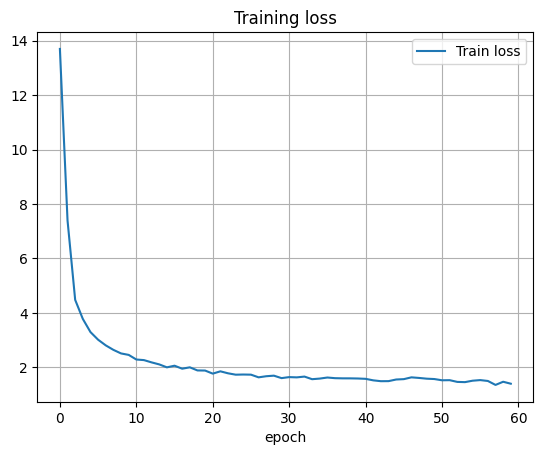

In [50]:
#Plotting graphs to visualize the progression of training and validation accuracy and loss curves
fig = plt.figure()



plt.plot(history_rsn.history['loss'], label='Train loss')
plt.plot(history_rsn.history['val_loss'], label='Val loss')
plt.legend(loc=0)
plt.title('Training loss')
plt.grid(True)
plt.xlabel('epoch')
plt.show()


# lr = 0.1

In [53]:
model_rsn3 = keras.Model(base_model_rsn.input, out)

#Compiling the model
model_rsn3.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.1),
    metrics=['accuracy']
)

In [55]:
#Setting checkpoints to save epochs with best validation accuracy
checkpoint_path = "training/cp-best.ckpt1"
checkpoint_dir = os.path.dirname(checkpoint_path)
callbacks = [ keras.callbacks.ModelCheckpoint(checkpoint_dir, monitor='val_accuracy', verbose=1, save_weights_only = True, save_best_only = True, mode='max')]

In [56]:
#Training the model
history_rsn3 = model_rsn.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=80,
    validation_steps=8,  
    epochs=30,
    verbose=1,
    callbacks = callbacks
)

Epoch 1/30
80/80 [==============================] - ETA: 0s - loss: 61.8825 - accuracy: 0.0527
Epoch 1: val_accuracy improved from -inf to 0.01172, saving model to training
80/80 [==============================] - 75s 935ms/step - loss: 61.8825 - accuracy: 0.0527 - val_loss: 227.9044 - val_accuracy: 0.0117
Epoch 2/30
80/80 [==============================] - ETA: 0s - loss: 63.7346 - accuracy: 0.0575
Epoch 2: val_accuracy improved from 0.01172 to 0.04297, saving model to training
80/80 [==============================] - 76s 950ms/step - loss: 63.7346 - accuracy: 0.0575 - val_loss: 123.1646 - val_accuracy: 0.0430
Epoch 3/30
80/80 [==============================] - ETA: 0s - loss: 61.0351 - accuracy: 0.0660
Epoch 3: val_accuracy improved from 0.04297 to 0.08203, saving model to training
80/80 [==============================] - 76s 950ms/step - loss: 61.0351 - accuracy: 0.0660 - val_loss: 75.4333 - val_accuracy: 0.0820
Epoch 4/30
80/80 [==============================] - ETA: 0s - loss: 62.

In [57]:
model_rsn3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

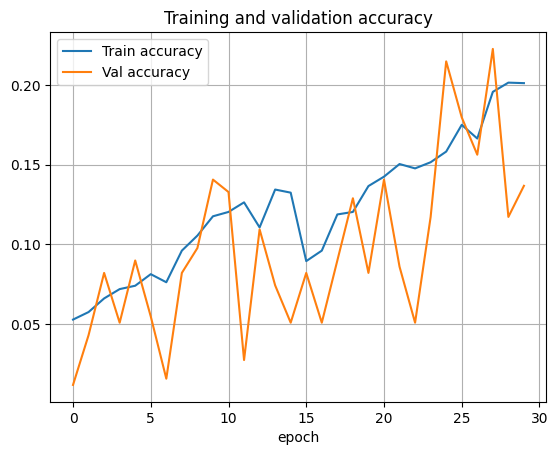

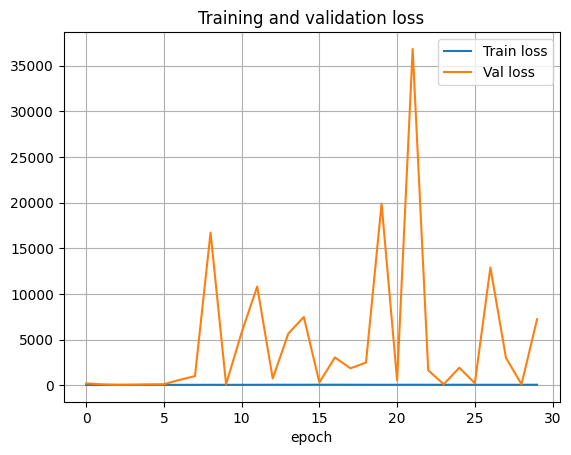

In [58]:
#Plotting graphs to visualize the progression of training and validation accuracy and loss curves
fig = plt.figure()

plt.plot(history_rsn3.history['accuracy'], label='Train accuracy')
plt.plot(history_rsn3.history['val_accuracy'], label='Val accuracy')
plt.legend(loc=0)
plt.title('Training and validation accuracy')
plt.grid(True)
plt.xlabel('epoch')
plt.show()

plt.plot(history_rsn3.history['loss'], label='Train loss')
plt.plot(history_rsn3.history['val_loss'], label='Val loss')
plt.legend(loc=0)
plt.title('Training and validation loss')
plt.grid(True)
plt.xlabel('epoch')
plt.show()

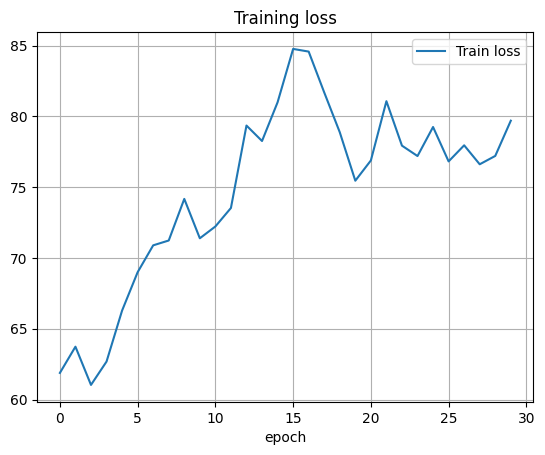

In [59]:
#Plotting graphs to visualize the progression of training and validation accuracy and loss curves
fig = plt.figure()



plt.plot(history_rsn3.history['loss'], label='Train loss')

plt.legend(loc=0)
plt.title('Training loss')
plt.grid(True)
plt.xlabel('epoch')
plt.show()

# lr = 0.05

In [61]:
model_rsn4 = keras.Model(base_model_rsn.input, out)

#Compiling the model
model_rsn4.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.05),
    metrics=['accuracy']
)

In [62]:
#Setting checkpoints to save epochs with best validation accuracy
checkpoint_path = "training/cp-best.ckpt4"
checkpoint_dir = os.path.dirname(checkpoint_path)
callbacks = [ keras.callbacks.ModelCheckpoint(checkpoint_dir, monitor='val_accuracy', verbose=1, save_weights_only = True, save_best_only = True, mode='max')]

In [63]:
#Training the model
history_rsn3 = model_rsn.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=80,
    validation_steps=8,  
    epochs=30,
    verbose=1,
    callbacks = callbacks
)

Epoch 1/30
80/80 [==============================] - ETA: 0s - loss: 75.5345 - accuracy: 0.2070
Epoch 1: val_accuracy improved from -inf to 0.17188, saving model to training
80/80 [==============================] - 75s 940ms/step - loss: 75.5345 - accuracy: 0.2070 - val_loss: 429961.9375 - val_accuracy: 0.1719
Epoch 2/30
80/80 [==============================] - ETA: 0s - loss: 75.9365 - accuracy: 0.2059
Epoch 2: val_accuracy improved from 0.17188 to 0.21875, saving model to training
80/80 [==============================] - 75s 936ms/step - loss: 75.9365 - accuracy: 0.2059 - val_loss: 285900.6250 - val_accuracy: 0.2188
Epoch 3/30
80/80 [==============================] - ETA: 0s - loss: 77.9544 - accuracy: 0.2172
Epoch 3: val_accuracy did not improve from 0.21875
80/80 [==============================] - 71s 888ms/step - loss: 77.9544 - accuracy: 0.2172 - val_loss: 58235.8164 - val_accuracy: 0.1875
Epoch 4/30
80/80 [==============================] - ETA: 0s - loss: 80.4317 - accuracy: 0.21

In [64]:
model_rsn3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

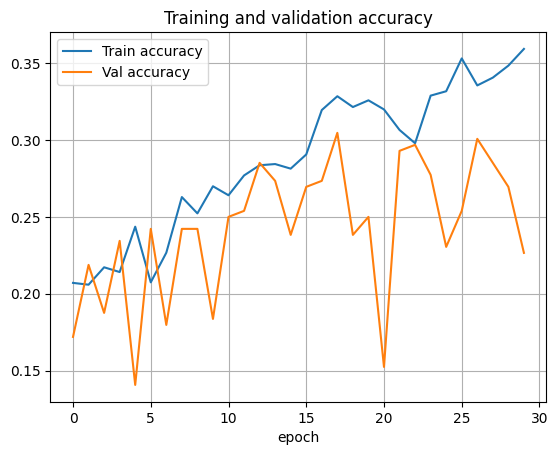

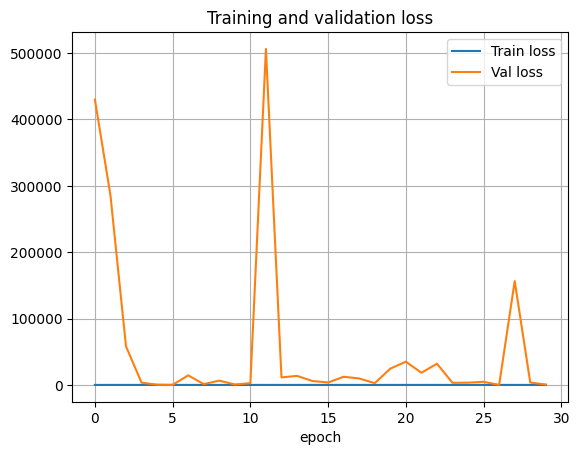

In [65]:
#Plotting graphs to visualize the progression of training and validation accuracy and loss curves
fig = plt.figure()

plt.plot(history_rsn3.history['accuracy'], label='Train accuracy')
plt.plot(history_rsn3.history['val_accuracy'], label='Val accuracy')
plt.legend(loc=0)
plt.title('Training and validation accuracy')
plt.grid(True)
plt.xlabel('epoch')
plt.show()

plt.plot(history_rsn3.history['loss'], label='Train loss')
plt.plot(history_rsn3.history['val_loss'], label='Val loss')
plt.legend(loc=0)
plt.title('Training and validation loss')
plt.grid(True)
plt.xlabel('epoch')
plt.show()

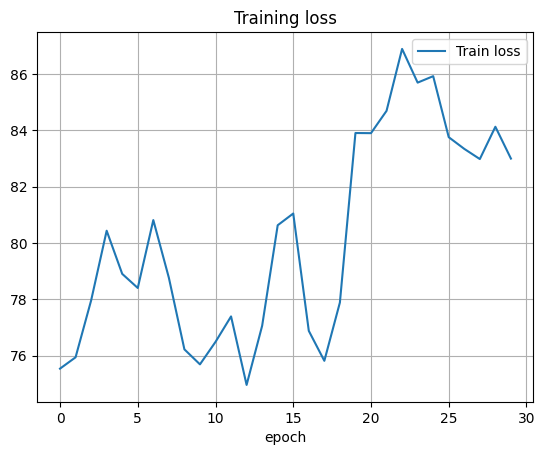

In [66]:
#Plotting graphs to visualize the progression of training and validation accuracy and loss curves
fig = plt.figure()



plt.plot(history_rsn3.history['loss'], label='Train loss')

plt.legend(loc=0)
plt.title('Training loss')
plt.grid(True)
plt.xlabel('epoch')
plt.show()

In [ ]:
model_rsn.save("model lib/ep=60_lr=0.1.model", save_format="h5")

In [ ]:
model_rsn = keras.models.load_model('carresnet50v2l_150e.model')

In [30]:
model_rsn_noval = keras.models.load_model('novalcarresnet50v2l_150e.model')

It can be concluded that lr = 0.01 is the best from the graph but there is overrfitting. lets try to improve the regularisation to see what can be done.

# Improving Regularisation

In [67]:
#increasing dropout and number of dense layer
base_model_rsn1 = keras.applications.ResNet50V2(
    weights = 'imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

#Architecture referenced from https://github.com/renxzen/stanfordDogs/blob/main/stanfordDogs.ipynb
x = keras.layers.Flatten()(base_model_rsn1.output)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(2048, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.4)(x)

out = keras.layers.Dense(196, activation='softmax')(x)

base_model_rsn1.trainable = False
for layer in base_model_rsn.layers:
    layer.trainable = False

In [68]:
model_rsn5 = keras.Model(base_model_rsn1.input, out)

#Compiling the model
model_rsn5.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy']
)

In [69]:
#Setting checkpoints to save epochs with best validation accuracy
checkpoint_path = "training/cp-best.ckpt5"
checkpoint_dir = os.path.dirname(checkpoint_path)
callbacks = [ keras.callbacks.ModelCheckpoint(checkpoint_dir, monitor='val_accuracy', verbose=1, save_weights_only = True, save_best_only = True, mode='max')]

In [70]:
history_rsn = model_rsn5.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=80,
    validation_steps=8,  
    epochs=150,
    verbose=1,
    callbacks = callbacks)

Epoch 1/30
80/80 [==============================] - ETA: 0s - loss: 8.4348 - accuracy: 0.0272
Epoch 1: val_accuracy improved from -inf to 0.03125, saving model to training
80/80 [==============================] - 79s 946ms/step - loss: 8.4348 - accuracy: 0.0272 - val_loss: 21.8316 - val_accuracy: 0.0312
Epoch 2/30
80/80 [==============================] - ETA: 0s - loss: 5.9706 - accuracy: 0.0695
Epoch 2: val_accuracy improved from 0.03125 to 0.08984, saving model to training
80/80 [==============================] - 75s 935ms/step - loss: 5.9706 - accuracy: 0.0695 - val_loss: 6.2176 - val_accuracy: 0.0898
Epoch 3/30
80/80 [==============================] - ETA: 0s - loss: 4.3635 - accuracy: 0.1169
Epoch 3: val_accuracy improved from 0.08984 to 0.15625, saving model to training
80/80 [==============================] - 75s 935ms/step - loss: 4.3635 - accuracy: 0.1169 - val_loss: 3.9414 - val_accuracy: 0.1562
Epoch 4/30
80/80 [==============================] - ETA: 0s - loss: 3.6197 - accu

In [72]:
model_rsn5.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

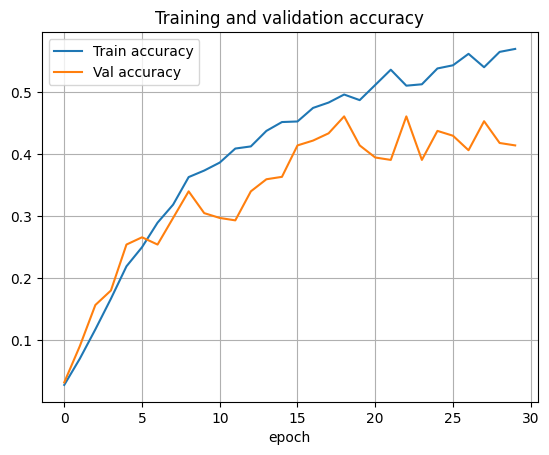

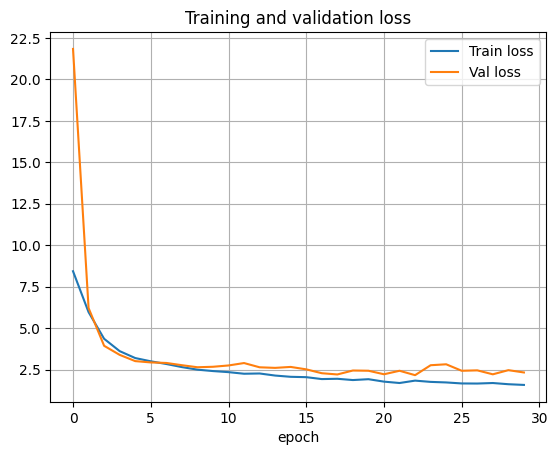

In [71]:
fig = plt.figure()

plt.plot(history_rsn.history['accuracy'], label='Train accuracy')
plt.plot(history_rsn.history['val_accuracy'], label='Val accuracy')
plt.legend(loc=0)
plt.title('Training and validation accuracy')
plt.grid(True)
plt.xlabel('epoch')
plt.show()

plt.plot(history_rsn.history['loss'], label='Train loss')
plt.plot(history_rsn.history['val_loss'], label='Val loss')
plt.legend(loc=0)
plt.title('Training and validation loss')
plt.grid(True)
plt.xlabel('epoch')
plt.show()

In [73]:
#Setting checkpoints to save epochs with best validation accuracy
checkpoint_path = "training/cp-best.ckpt6"
checkpoint_dir = os.path.dirname(checkpoint_path)
callbacks = [ keras.callbacks.ModelCheckpoint(checkpoint_dir, monitor='val_accuracy', verbose=1, save_weights_only = True, save_best_only = True, mode='max')]

In [76]:
model_rsn6 = keras.Model(base_model_rsn1.input, out)

#Compiling the model
model_rsn6.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy']
)

In [77]:
history_rsn = model_rsn6.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=80,
    validation_steps=8,  
    epochs=150,
    verbose=1,
    callbacks = callbacks)

Epoch 1/150
80/80 [==============================] - ETA: 0s - loss: 1.8796 - accuracy: 0.5159
Epoch 1: val_accuracy improved from -inf to 0.39453, saving model to training
80/80 [==============================] - 79s 945ms/step - loss: 1.8796 - accuracy: 0.5159 - val_loss: 2.4338 - val_accuracy: 0.3945
Epoch 2/150
80/80 [==============================] - ETA: 0s - loss: 1.7195 - accuracy: 0.5457
Epoch 2: val_accuracy improved from 0.39453 to 0.44141, saving model to training
80/80 [==============================] - 75s 938ms/step - loss: 1.7195 - accuracy: 0.5457 - val_loss: 2.4677 - val_accuracy: 0.4414
Epoch 3/150
80/80 [==============================] - ETA: 0s - loss: 1.8022 - accuracy: 0.5301
Epoch 3: val_accuracy did not improve from 0.44141
80/80 [==============================] - 72s 899ms/step - loss: 1.8022 - accuracy: 0.5301 - val_loss: 2.6602 - val_accuracy: 0.3750
Epoch 4/150
80/80 [==============================] - ETA: 0s - loss: 1.7183 - accuracy: 0.5383
Epoch 4: val_a

In [ ]:
model_rsn6.summary()

In [ ]:
fig = plt.figure()

plt.plot(history_rsn.history['accuracy'], label='Train accuracy')
plt.plot(history_rsn.history['val_accuracy'], label='Val accuracy')
plt.legend(loc=0)
plt.title('Training and validation accuracy')
plt.grid(True)
plt.xlabel('epoch')
plt.show()

plt.plot(history_rsn.history['loss'], label='Train loss')
plt.plot(history_rsn.history['val_loss'], label='Val loss')
plt.legend(loc=0)
plt.title('Training and validation loss')
plt.grid(True)
plt.xlabel('epoch')
plt.show()

In [ ]:
model_rsn.save("ep=60_lr=0.01_reg_ldl.model", save_format="h5")

# Testing

In [64]:
loss, acc = model_rsn.evaluate(val_gen) #evaluating ResNet50V2 model on new validation set
print(f"val_loss: {loss}, val_acc:{round(acc*100,2)}%")

20/20 [==============================] - 36s 2s/step - loss: 2.2676 - accuracy: 0.5437
val_loss: 2.2675986289978027, val_acc:54.37%


In [65]:
loss, acc = model_rsn_noval.evaluate(val_gen) #evaluating ResNet50V2 model on new validation set
print(f"val_loss: {loss}, val_acc:{round(acc*100,2)}%")

20/20 [==============================] - 35s 2s/step - loss: 2.4290 - accuracy: 0.5527
val_loss: 2.429030179977417, val_acc:55.27%


# setting the test data

In [47]:
with open('stanford car/cars_data_test.csv', 'w+') as f:
    [f.write('TEST,%s,%s%s,%s,%s,%s,%s,%s,%s\n' %(test_path, org_path, img, bbox_x1, bbox_x2, bbox_y1, bbox_y2, lab,img)) for img, bbox_x1, bbox_x2, bbox_y1, bbox_y2, lab in test]


In [49]:
data_met_T = pd.read_csv('stanford car/cars_data_test.csv')
data_met_T

,type,org_path,path,xmin,ymin,xmax,ymax,label,img
0,TEST,stanford car/cars_test/cars_test/,stanford car/cars_train/cars_train/01587.jpg,32,162,2577,1730,Nissan Juke Hatchback 2012,01587.jpg
1,TEST,stanford car/cars_test/cars_test/,stanford car/cars_train/cars_train/01456.jpg,35,63,464,331,GMC Yukon Hybrid SUV 2012,01456.jpg
2,TEST,stanford car/cars_test/cars_test/,stanford car/cars_train/cars_train/01642.jpg,13,122,480,286,Honda Odyssey Minivan 2012,01642.jpg
3,TEST,stanford car/cars_test/cars_test/,stanford car/cars_train/cars_train/01824.jpg,55,31,341,238,Toyota Sequoia SUV 2012,01824.jpg
4,TEST,stanford car/cars_test/cars_test/,stanford car/cars_train/cars_train/00985.jpg,79,64,281,190,BMW X3 SUV 2012,00985.jpg
...,...,...,...,...,...,...,...,...,...
1623,TEST,stanford car/cars_test/cars_test/,stanford car/cars_train/cars_train/01402.jpg,41,60,226,165,GMC Terrain SUV 2012,01402.jpg
1624,TEST,stanford car/cars_test/cars_test/,stanford car/cars_train/cars_train/01749.jpg,7,52,130,129,MINI Cooper Roadster Convertible 2012,01749.jpg
1625,TEST,stanford car/cars_test/cars_test/,stanford car/cars_train/cars_train/01099.jpg,246,681,1344,1069,Bugatti Veyron 16.4 Convertible 2009,01099.jpg
1626,TEST,stanford car/cars_test/cars_test/,stanford car/cars_train/cars_train/01737.jpg,27,41,635,459,Hyundai Tucson SUV 2012,01737.jpg


In [50]:
#removing '/' before creating folder as it is a problem to give paths
data_met_T['label'] = data_met_T['label'].str.replace('/','')
brand_t = data_met_T['label'].unique()
len(brand_t)

196

In [63]:
#creating a new folder to store cropped car images
os.mkdir('stanford car/test_data')
for brands in brand_t:
    os.mkdir('stanford car/test_data/' + brands)
print('Created {} folders to store test images of the different types.'.format(len(os.listdir('stanford car/test_data'))))

Created 196 folders to store test images of the different types.


In [64]:
for i in range(0,1627):
    a =data_met_T['path'][i]
    # xmin = int(train_data_met['xmin'][i])
    # ymin = int(train_data_met['ymin'][i])
    # xmax = int(train_data_met['xmax'][i])
    # ymax = int(train_data_met['ymax'][i])
    print(i,a)
    img = Image.open(a)
    #img = img.crop((xmin, ymin, xmax, ymax))
    img = img.convert('RGB')
    img = img.resize((224, 224))
    filename = train_data_met['img'][i]
    img.save('stanford car/test_data/' + data_met_T['label'][i] + '/'+filename)

0 stanford car/cars_train/cars_train/01587.jpg
1 stanford car/cars_train/cars_train/01456.jpg
2 stanford car/cars_train/cars_train/01642.jpg
3 stanford car/cars_train/cars_train/01824.jpg
4 stanford car/cars_train/cars_train/00985.jpg
5 stanford car/cars_train/cars_train/02369.jpg
6 stanford car/cars_train/cars_train/01794.jpg
7 stanford car/cars_train/cars_train/02248.jpg
8 stanford car/cars_train/cars_train/01296.jpg
9 stanford car/cars_train/cars_train/01718.jpg
10 stanford car/cars_train/cars_train/00958.jpg
11 stanford car/cars_train/cars_train/02381.jpg
12 stanford car/cars_train/cars_train/01860.jpg
13 stanford car/cars_train/cars_train/01717.jpg
14 stanford car/cars_train/cars_train/01832.jpg
15 stanford car/cars_train/cars_train/02399.jpg
16 stanford car/cars_train/cars_train/00828.jpg
17 stanford car/cars_train/cars_train/01843.jpg
18 stanford car/cars_train/cars_train/01075.jpg
19 stanford car/cars_train/cars_train/01940.jpg
20 stanford car/cars_train/cars_train/01001.jpg
21

In [71]:
test_directory = "stanford car/test_data/"
sd_gen_t = ImageDataGenerator(
    rescale = 1./255,
)

test_gen = sd_gen_t.flow_from_directory(
    test_directory,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1627 images belonging to 196 classes.


In [68]:
loss_test, acc_test = model_rsn.evaluate(test_gen) #evaluating ResNet50V2 model on fresh test set
print(f"test_loss: {loss_test}, test_acc:{round(acc_test*100,2)}%")

51/51 [==============================] - 49s 965ms/step - loss: 5.2543 - accuracy: 0.3141
test_loss: 5.254340171813965, test_acc:31.41%


In [69]:
# Get the class labels
class_labels = list(test_gen.class_indices.keys())

# Retrieve the filenames and labels
filenames = test_gen.filenames
labels = test_gen.labels

# Iterate over the filenames and corresponding labels
for filename, label in zip(filenames, labels):
    # Retrieve the corresponding class label
    class_label = class_labels[label]

    # Print the filename and the associated class label
    print(f"Filename: {filename}, Class Label: {class_label}")

Filename: AM General Hummer SUV 2000\02457.jpg, Class Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\02763.jpg, Class Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\02847.jpg, Class Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03147.jpg, Class Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03285.jpg, Class Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03286.jpg, Class Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03505.jpg, Class Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03529.jpg, Class Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03573.jpg, Class Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03701.jpg, Class Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03924.jpg, Class Label: AM General Hummer SUV 2000
Filename: Acura Integra Type R 2

In [107]:
class_labels[51]

'Cadillac Escalade EXT Crew Cab 2007'

In [72]:
# Get the class labels
class_labels = list(test_gen.class_indices.keys())

# Retrieve the filenames, true labels, and predicted labels
filenames = test_gen.filenames
labels = test_gen.labels

# Predict labels for the test set
predictions = model_rsn.predict(test_gen)
predicted_labels = np.argmax(predictions, axis=1)  # Get the index of the class with the highest probability

# Iterate over the filenames, true labels, and predicted labels
for filename, true_label, predicted_label in zip(filenames, labels, predicted_labels):
    # Retrieve the corresponding class labels
    true_class_label = class_labels[true_label]
    predicted_class_label = class_labels[predicted_label]

    # Print the filename, true label, and predicted label
    print(f"Filename: {filename}, True Label: {true_class_label}, Predicted Label: {predicted_class_label}")

51/51 [==============================] - 50s 971ms/step
Filename: AM General Hummer SUV 2000\02457.jpg, True Label: AM General Hummer SUV 2000, Predicted Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\02763.jpg, True Label: AM General Hummer SUV 2000, Predicted Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\02847.jpg, True Label: AM General Hummer SUV 2000, Predicted Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03147.jpg, True Label: AM General Hummer SUV 2000, Predicted Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03285.jpg, True Label: AM General Hummer SUV 2000, Predicted Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03286.jpg, True Label: AM General Hummer SUV 2000, Predicted Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03505.jpg, True Label: AM General Hummer SUV 2000, Predicted Label: Jeep Wrangler SUV 2012
Filename: AM General Hum